In [1]:
!pip install pandas
!pip install hyperopt
!pip install utils
!pip install shap

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Using cached utils-1.0.1-py2.py3-none-any.whl (21 kB)
  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/04/cd/c8bd38eb610f9b80b970f6e98ab88dbc0e017dbbc406248381bb77ae626f/shap-0.44.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached shap-0.44.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (24 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
Using cached shap-0.44.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (533 kB)


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from utils import * 

import xgboost as xgb
print("xgboost version = ",xgb.__version__)

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# import packages for SHAP values and force plots
import shap
import ipywidgets as widgets


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False


xgboost version =  1.7.6


In [3]:
#Open the data
import pandas as pd
file_path = 'Me3_soil.csv'
me_data = pd.read_csv(file_path)
print(me_data.head())

   TIMESTAMP_START  TIMESTAMP_END  TA_ERA  SW_IN_ERA  LW_IN_ERA  VPD_ERA  \
0     2.000000e+11   2.000000e+11  -3.192        0.0    294.202    1.242   
1     2.000000e+11   2.000000e+11  -3.198        0.0    294.202    1.238   
2     2.000000e+11   2.000000e+11  -3.205        0.0    303.972    1.234   
3     2.000000e+11   2.000000e+11  -3.145        0.0    303.972    1.230   
4     2.000000e+11   2.000000e+11  -3.086        0.0    303.972    1.225   

   PA_ERA  P_ERA  SWC_F_MDS_1  TS_F_MDS_1  ...  NEE_CUT_MEAN  NEE_VUT_MEAN  \
0  88.967  0.074        17.75       0.551  ...      0.781931      0.741283   
1  88.952  0.074        17.75       0.563  ...      0.781931      0.741283   
2  88.937  0.226        17.75       0.612  ...      0.781931      0.741283   
3  88.913  0.000        17.75       0.643  ...      0.781931      0.741283   
4  88.888  0.000        17.75       0.646  ...      0.781931      0.741283   

   RECO_NT_VUT_MEAN  RECO_NT_CUT_MEAN  GPP_NT_VUT_MEAN  GPP_NT_CUT_MEAN  \

### 1. data preprocssing: prepare data for training & test sets

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Replace '-9999' with NaN
me_data[['SWC_F_MDS_1', 'TS_F_MDS_1']] = me_data[['SWC_F_MDS_1', 'TS_F_MDS_1']].replace(-9999, np.nan)

# Fill NaN values with median
me_data['SWC_F_MDS_1'].fillna(me_data['SWC_F_MDS_1'].median(), inplace=True)
me_data['TS_F_MDS_1'].fillna(me_data['TS_F_MDS_1'].median(), inplace=True)

# definition
features = me_data[['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'PA_ERA', 'P_ERA', 'WS_ERA','SWC_F_MDS_1','TS_F_MDS_1']]
labels = me_data[['NEE_CUT_MEAN']]

# devide test and training sets（random）
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

### 2. Build & train the xgboost model with multi-output regressor; plot the predictions for evaluations

MultiOutputRegressor train one regressor per target. Target: air temperature at each grid point.

Noted that MultiOutputRegressor does not leverage any possible relation between targets.

#### Option 1: randomly select a hyperparameter setting

parameter setting in xgboost regressor: check <a href="https://xgboost.readthedocs.io/en/stable/parameter.html">here</a>


In [5]:
# set up xgboost regressor
n_estimators  = 30     # specifies the number of decision trees to be boosted
learning_rate = 0.2    # learning_rate, range: [0,1]
gamma         = 3      # Minimum loss reduction required to make a further partition on a leaf node of the tree,
                       # range: [0,∞]
max_depth     = 10     # Maximum depth of a tree, range: [0,∞]
subsample     = 0.8    # Subsample ratio of the training instances, range: (0,1]
lamb          = 0.8    # L2 regularization, range: [0,∞]
alpha         = 0.2    # L1 regularization, range: [0,∞]
tree_method   = 'hist' # The tree construction algorithm used in XGBoost
eval_metric   = 'rmse' # Evaluation metrics for validation data; 
                       # Options: rmse, rmsle, mae, mape, logloss, etc
seed          = 5      # random number seed

xgb_regressor1 = XGBRegressor(n_estimators = n_estimators,
                              eta = learning_rate,
                              gamma = gamma,
                              max_depth = max_depth,
                              subsample = subsample,
                              reg_lambda = lamb,
                              reg_alpha = alpha,
                              tree_method = tree_method,
                              eval_metric = eval_metric,
                              seed = seed,
                              verbosity = 1)


In [6]:
# sklearn.multioutput.MultiOutputRegressor as a wrapper of xgb.XGBRegressor
multioutput_regressor1 = MultiOutputRegressor(xgb_regressor1)
multioutput_regressor1.fit(X_train, y_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.2,
                                            eval_metric='rmse',
                                            feature_types=None, gamma=3,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=30, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, ...))

Evaluate the model

In [7]:
# generate predictions
y_test_pred1 = multioutput_regressor1.predict(X_test)

# evaluate the predictions
mae1 = mean_absolute_error(y_test, y_test_pred1)
print(f"Mean Absolute Error: {mae1}")

rmse1 = mean_squared_error(y_test, y_test_pred1, squared=False)
print(f"Root Mean Squared Error: {rmse1}")

# Make predictions as a frame
import pandas as pd

predicted_labels = ['NEE_CUT_MEAN']
predictions_df = pd.DataFrame(y_test_pred1, columns=predicted_labels)



Mean Absolute Error: 0.7468513758398669
Root Mean Squared Error: 1.110518966297179


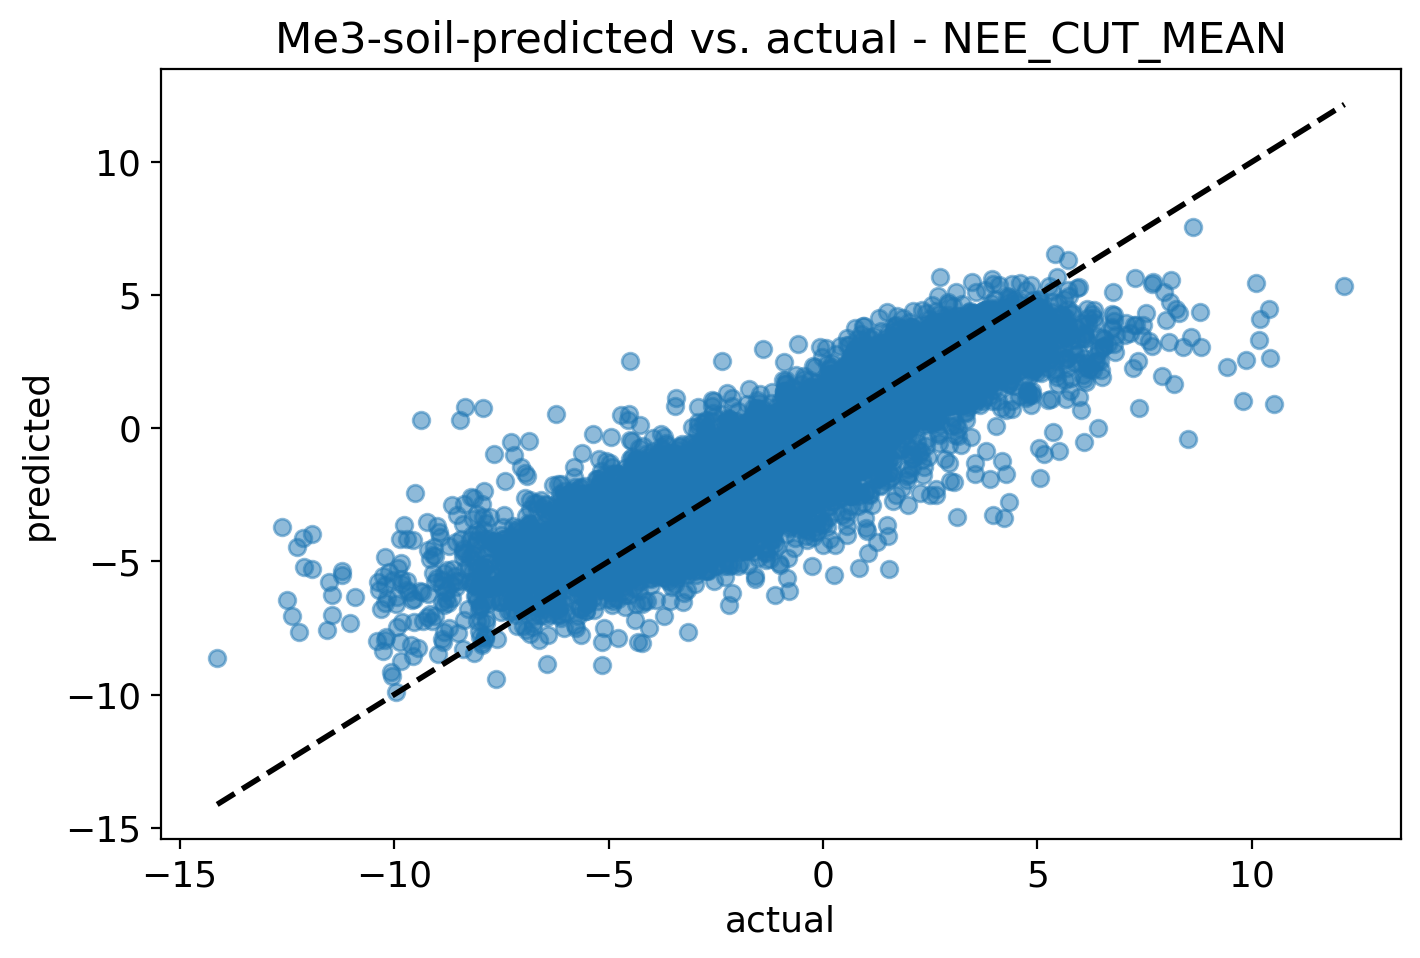

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

for i, label in enumerate(predicted_labels):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test[predicted_labels[i]], y_test_pred1[:, i], alpha=0.5)
    plt.title(f'Me3-soil-predicted vs. actual - {label}')
    plt.xlabel('actual')  
    plt.ylabel('predicted')  
    
    min_val = min(y_test[predicted_labels[i]].min(), y_test_pred1[:, i].min())
    max_val = max(y_test[predicted_labels[i]].max(), y_test_pred1[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    plt.show()


In [9]:
# calculate R2
from sklearn.metrics import r2_score
# y_test_pred1 = model.predict(X_test)
r2_scores = r2_score(y_test, y_test_pred1, multioutput='raw_values')
print(r2_scores)


[0.8236968]


SHAP values for output NEE_CUT_MEAN:


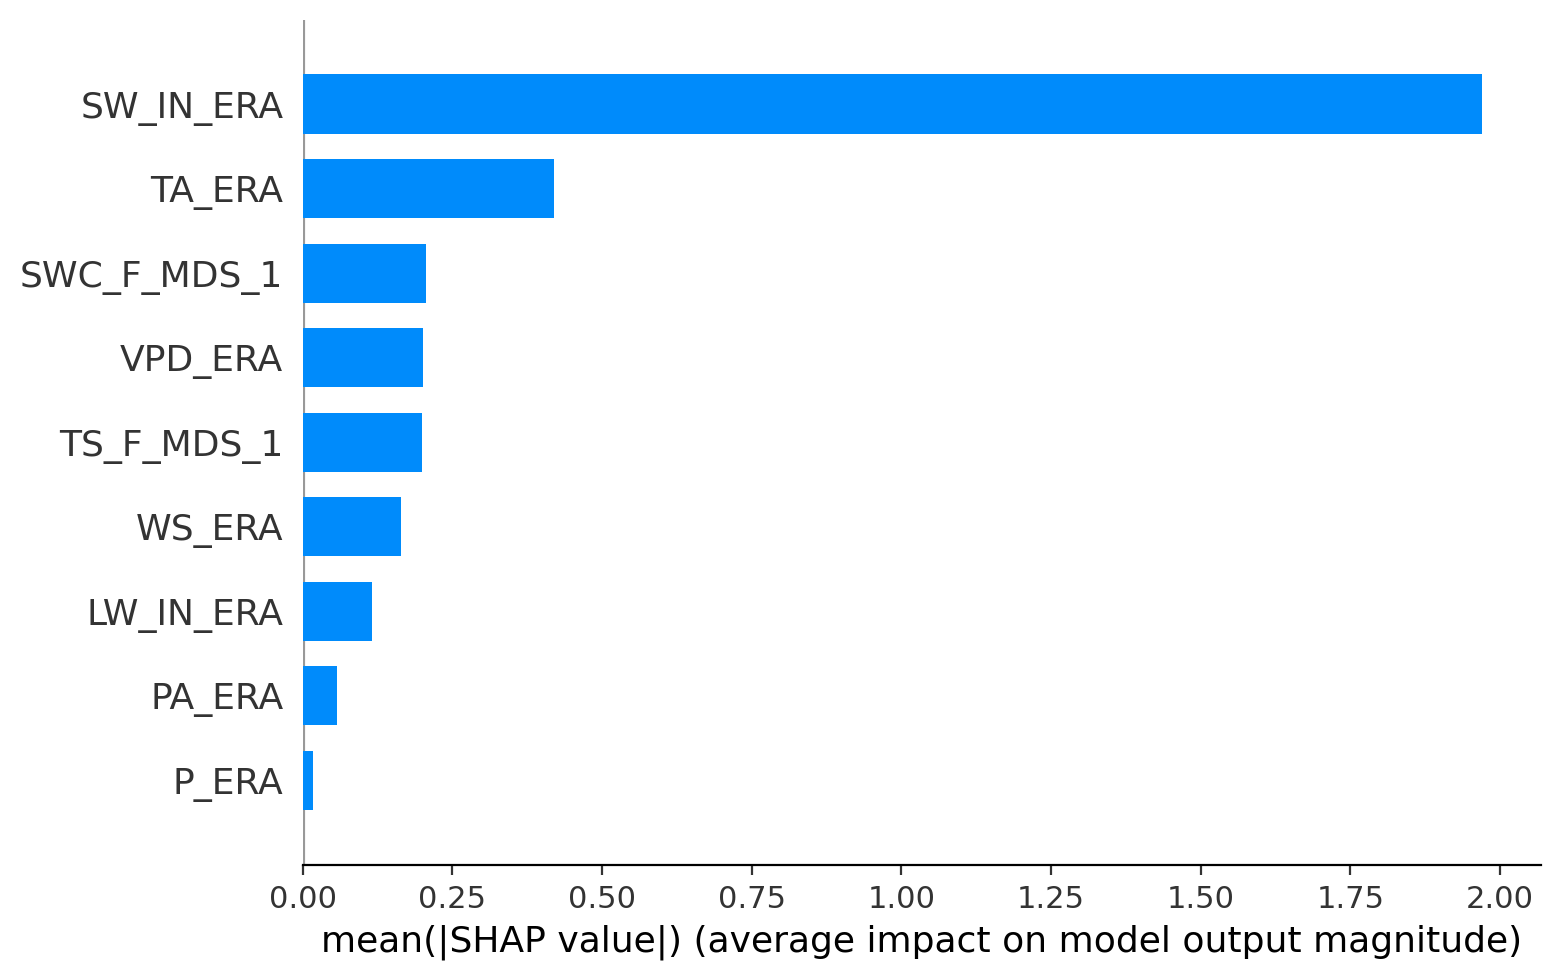

In [10]:
# calculate SHAP value
for i, model in enumerate(multioutput_regressor1.estimators_):
   
    explainer = shap.Explainer(model)

    shap_values = explainer.shap_values(X_test)

    print(f"SHAP values for output {predicted_labels[i]}:")
    shap.summary_plot(shap_values, X_test, plot_type="bar")

#### Option 2: apply hyperparameter tuning to find the best parameter

One may also perform hyperparameter tuning by using hyperopt package. Reference: <a href="https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning">xgboost hyperparameter tuing</a>


In [11]:
# hyperparameters option list
n_estimators_list = [int(x) for x in np.linspace(start=20, stop=100, num=9)]
max_depth_list = [5, 10, 15, 20]
reg_alpha_list = [0.1, 0.2, 0.3]
reg_lambda_list = [0.7, 0.8, 0.9]
subsample_list = [0.6, 0.7, 0.8, 0.9, 1]
eta_list = [0.05, 0.1, 0.15, 0.2]
eval_metric_list = ['rmse','mae','mape','logloss']

# Initialize domain space for range of values 
space={'n_estimators': hp.choice('n_estimators', n_estimators_list),
       'max_depth': hp.choice("max_depth", max_depth_list),
       'gamma': hp.uniform ('gamma', 1, 9),
       'reg_alpha' : hp.choice('reg_alpha', reg_alpha_list),
       'reg_lambda' : hp.choice('reg_lambda', reg_lambda_list),
       'subsample' : hp.choice('subsample', subsample_list),
       'eta' : hp.choice('eta', eta_list),
       'eval_metric' : hp.choice('eval_metric', eval_metric_list),
       'tree_method' : 'hist',
       'seed': 5
    }


In [12]:
# define objective function
def objective(space):
    n_estimators = space['n_estimators']
    learning_rate = space['eta']
    gamma = space['gamma']
    max_depth = int(space['max_depth'])
    subsample = space['subsample']
    lamb = space['reg_lambda']
    alpha = space['reg_alpha']
    eval_metric = space['eval_metric']
    seed = space['seed']
    
    xgb_regressor = XGBRegressor(n_estimators = n_estimators,
                                 eta = learning_rate,
                                 gamma = gamma,
                                 max_depth = max_depth,
                                 subsample = subsample,
                                 reg_lambda = lamb,
                                 reg_alpha = alpha,
                                 tree_method = 'hist',
                                 eval_metric = eval_metric,
                                 seed = 5,
                                 verbosity = 1)

    
    multioutput_regressor = MultiOutputRegressor(xgb_regressor)
    multioutput_regressor.fit(X_train, y_train)
    
    y_test_pred = multioutput_regressor.predict(X_test)
    rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    print("loss (rmse): "+str(rmse))
    print("n_estimators = "+str(n_estimators)+"; eta = "+str(learning_rate)+"; gamma = "+str(gamma)+"; max_depth = "+str(max_depth))
    print("subsample = "+str(subsample)+"; reg_lambda = "+str(lamb)+"; reg_alpha = "+str(alpha)+"; eval_metric = "+str(eval_metric))
    print('----------------------------------------------------------------------------------------')
    return {'loss': rmse, 'status': STATUS_OK }

In [13]:
# find the best hyperparameters of 10 trials
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)


loss (rmse): 1.116592243460549                        
n_estimators = 70; eta = 0.15; gamma = 5.578193725230455; max_depth = 10
subsample = 0.6; reg_lambda = 0.7; reg_alpha = 0.1; eval_metric = mae
----------------------------------------------------------------------------------------
loss (rmse): 1.2123961785430906                                                
n_estimators = 90; eta = 0.15; gamma = 6.586885026647424; max_depth = 5        
subsample = 1; reg_lambda = 0.8; reg_alpha = 0.2; eval_metric = rmse           
----------------------------------------------------------------------------------------
loss (rmse): 1.3525084517507964                                                
n_estimators = 40; eta = 0.05; gamma = 4.025148258747049; max_depth = 5        
subsample = 1; reg_lambda = 0.8; reg_alpha = 0.3; eval_metric = rmse           
----------------------------------------------------------------------------------------
loss (rmse): 1.3060711374379097                        

In [14]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams) # if hp.choice, the output is the position of the list
print("eta = ", eta_list[best_hyperparams['eta']]) # an example of find the exact value of the position


The best hyperparameters are :  

{'eta': 1, 'eval_metric': 3, 'gamma': 1.9387325902943218, 'max_depth': 1, 'n_estimators': 5, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 4}
eta =  0.1


In [15]:
# build a regressor with the best hyperparameters
xgb_regressor2 = XGBRegressor(n_estimators = n_estimators_list[best_hyperparams['n_estimators']],
                              eta = eta_list[best_hyperparams['eta']],
                              gamma = best_hyperparams['gamma'],
                              max_depth = max_depth_list[best_hyperparams['max_depth']],
                              subsample = subsample_list[best_hyperparams['subsample']],
                              reg_lambda = reg_lambda_list[best_hyperparams['reg_lambda']],
                              reg_alpha = reg_alpha_list[best_hyperparams['reg_alpha']],
                              tree_method = 'hist',
                              eval_metric = eval_metric_list[best_hyperparams['eval_metric']],
                              seed = 5,
                              verbosity = 1)

multioutput_regressor2 = MultiOutputRegressor(xgb_regressor2)
multioutput_regressor2.fit(X_train, y_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.1,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            gamma=1.9387325902943218,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=70, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, ...))

Evaluate the model

Mean Absolute Error: 0.7304908992010676
Root Mean Squared Error: 1.0918653528688709


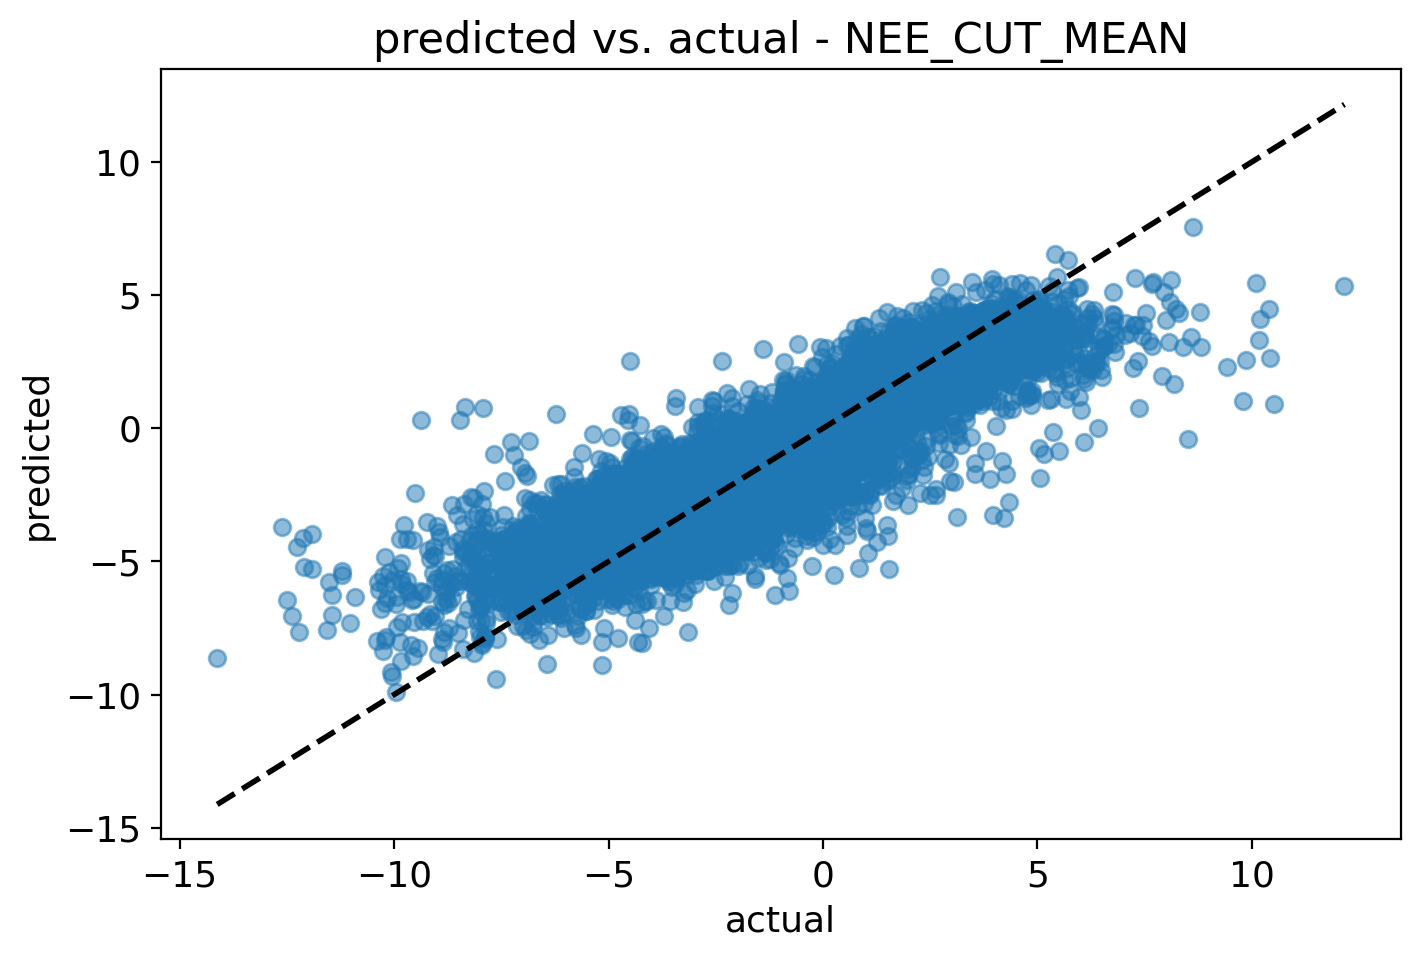

In [17]:
# generate predictions
y_test_pred2 = multioutput_regressor2.predict(X_test)

# evaluate the predictions
mae2 = mean_absolute_error(y_test, y_test_pred2)
print(f"Mean Absolute Error: {mae2}")

rmse2 = mean_squared_error(y_test, y_test_pred2, squared=False)
print(f"Root Mean Squared Error: {rmse2}")

import matplotlib.pyplot as plt



import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

predicted_labels = ['NEE_CUT_MEAN']
predictions_df = pd.DataFrame(y_test_pred2, columns=predicted_labels)

# scatter plot
for i, label in enumerate(predicted_labels):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test[predicted_labels[i]], y_test_pred1[:, i], alpha=0.5)
    plt.title(f'predicted vs. actual - {label}')
    plt.xlabel('actual')  
    plt.ylabel('predicted')  
   
    min_val = min(y_test[predicted_labels[i]].min(), y_test_pred1[:, i].min())
    max_val = max(y_test[predicted_labels[i]].max(), y_test_pred1[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    plt.show()



In [18]:
# calculate R2
from sklearn.metrics import r2_score

# y_test_pred1 = model.predict(X_test)

r2_scores = r2_score(y_test, y_test_pred1, multioutput='raw_values')

print(r2_scores)

[0.8236968]


SHAP values for output NEE_CUT_MEAN:


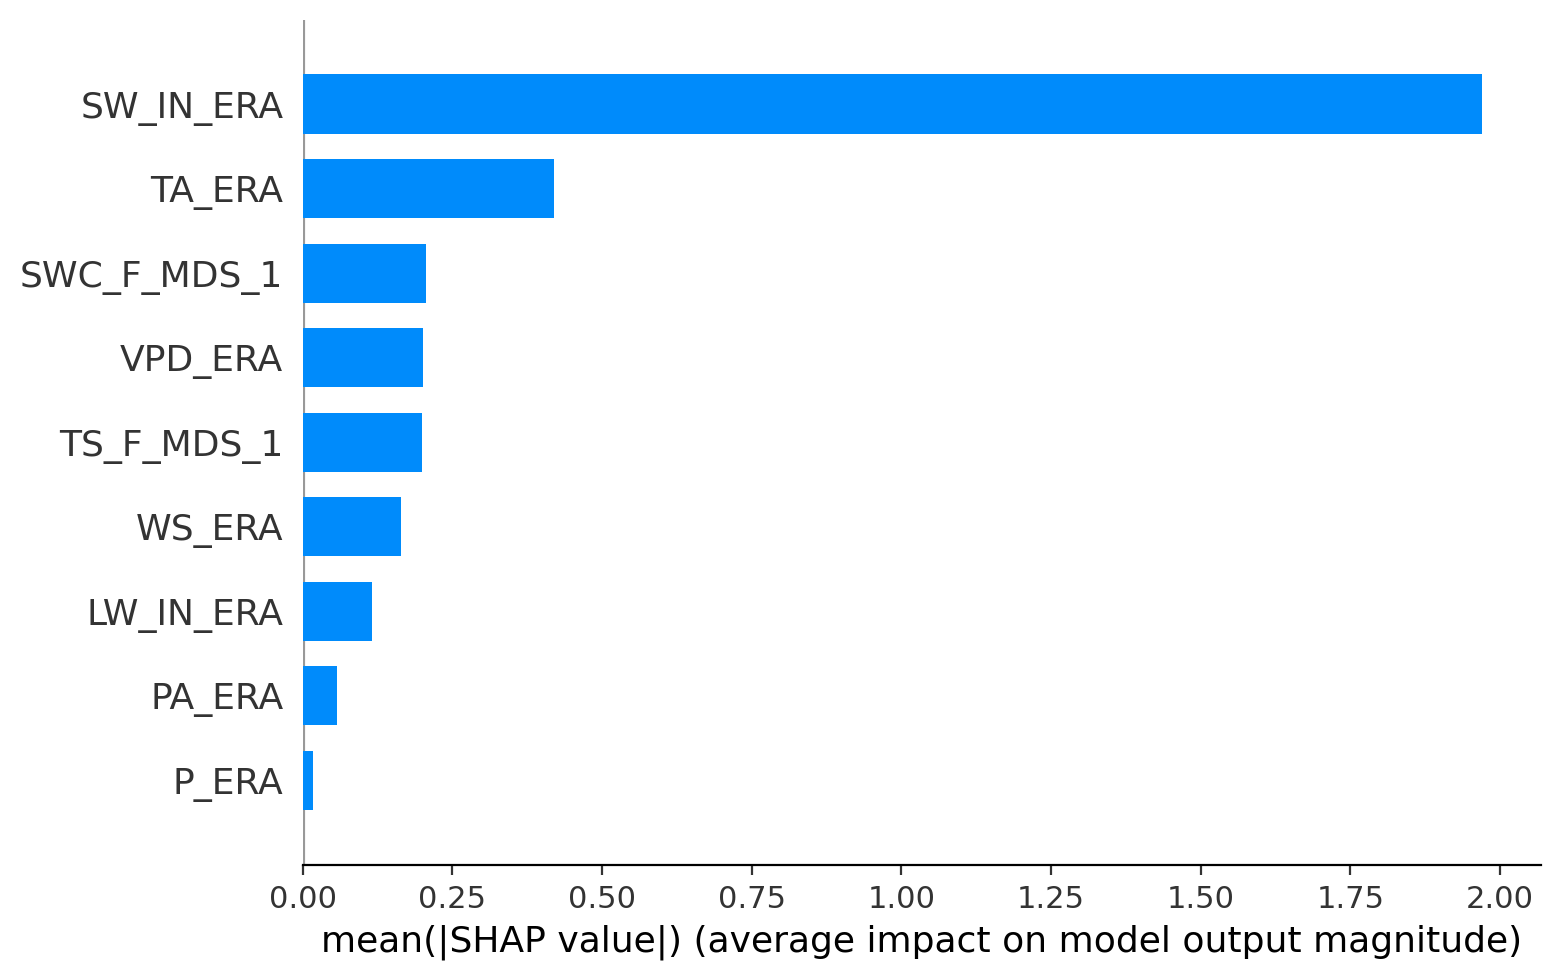

In [19]:
# calculate SHAP value
for i, model in enumerate(multioutput_regressor1.estimators_):
   
    explainer = shap.Explainer(model)

    shap_values = explainer.shap_values(X_test)

    print(f"SHAP values for output {predicted_labels[i]}:")
    shap.summary_plot(shap_values, X_test, plot_type="bar")